<a href="https://colab.research.google.com/github/amogh-code2021/Tutorials_1/blob/master/VC_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = 6>**Overview**</font>

This project is done by Amogh Deshpande currently studying MSc. Advanced Computer Science with AI, registration number 202173605.
This project is of building object detection models for the global wheat detection dataset. The object detection is done by using 2 seperate models i.e. Faster RCNN and YOLOv5 Multiple processes have been incorpporated in order to build and enhance these models such as image augmentation and albumentation. 

It was found that given the same inputs Yolov5 performed better in comparison with a MAP@.95 value of 0.459 as compared to that of Faster RCNN at 0.399.


<font size = 6>**Methodology**</font>

Methodolgy can be defined in the following steps



1.   Importing and installing all the required packages for building the models
2.   Check GPU setup as the model needs GPU to train
3.   Loading the training data
4.   Setting standardised variables to be used for both models
5.   Creating datasets in required format for both models (further description will be given below)
6.   Load both models
7.   Train models on training datasets and validate them on validation datasets
8.   Compare results between the models







<font size= 5>**Importing required packages**</font>

For this project primarily pytorch will be used followed by other necessary packages


In [ ]:
import os
from os.path import exists
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as T 

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
! pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Glob
from glob import glob

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

#For file movements
import shutil

#Image conversion
from PIL import Image

In [ ]:
# Lets check our Hardware first
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Apr  1 18:25:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<font size = 4>**Setting up working directory**</font>

In [ ]:
os.chdir('/content/drive/MyDrive/wheat_data/global-wheat-detection')

<font size = 4>**Loading train dataset**</font>

In [ ]:
data_total = pd.read_csv((str(os.getcwd() + '/train.csv')))

<font size = 3>**Standard Variables to be used**</font>

The minimum Image size for FasterRCNN is 800 and the maximum is 1333 for pytorch, so resizing seemed unnecessary (as it is already 1024x1024). Further optimizer for FCNN was setup with a learning rate of 0.05

In [ ]:
n_folds = 5
seed = 2020
num_classes = 2
BATCH_SIZE = 8
LR = 0.05

##We go for 10 epochs for demonstration purposes, as the time taken for Faster RCNN is quite high
EPOCHS = 10
img_size_training = 1024

Adam = False
if Adam: 
    Adam_config = {"lr" : 0.001, "betas" : (0.9, 0.999), "eps" : 1e-08}
else:
    SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.001}

<font size = 3>**Seed everything for reproducability**</font>

In [ ]:
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

<font size = 4>**Setting up data for Faster RCNN**</font>

Created a cross-validation split in which the folds are made by preserving the percentage of samples for each of the following "classes":



1.   Number of Boxes
2.   Source



In [ ]:
def create_data_frcnn(data,n_fold,fold):
  # get an array of arrays of all bboxes in the form [[x], [y], [w], [h]]
  bboxs = np.stack(data['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep = ',')))
  # save the values in the respective column
  data_1 = data.copy()
  for i, column in enumerate(['x', 'y', 'w', 'h']):
      data_1[column] = bboxs[:,i]
  data_1.drop(columns=['bbox'], inplace=True)

  # Creating stratified Folds
  skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)

  df_folds = data_1[['image_id']].copy()
  df_folds.loc[:, 'bbox_count'] = 1

  # get number of bboxes for each image_id
  df_folds = df_folds.groupby('image_id').count()

  # add [source] column
  df_folds.loc[:, 'source'] = data[['image_id', 'source']].groupby('image_id').min()['source']

  # concat two arays of strings: source and (_bboxcount // 15) to separate into folds
  df_folds.loc[:, 'stratify_group'] = np.char.add(
      df_folds['source'].values.astype(str),
      df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str))
  df_folds.loc[:, 'fold'] = 0

  for fold_number, (train_index, val_index) in enumerate(skf.split(        
          X = df_folds.index,
          y = df_folds['stratify_group'])):
      df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

  return data_1, df_folds[df_folds['fold'] != 0],df_folds[df_folds['fold'] == 0]
    

<font size = 4>**Setting up data for Yolov5**</font>

Using the datasets created for Faster RCNN we create a similar datset for the input of yolov5 model.

In [ ]:
def create_data_yolo(data,df_train_frcnn,df_val_frcnn):
  data = data.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')
  
  val_img_id = df_val_frcnn['bbox_count'].index.values
  train_img_id = df_train_frcnn['bbox_count'].index.values

  #Get validation data for yolo
  temp_data = []
  for id in val_img_id:
    temp_data.append([id, data[data['image_id'] == id]['bboxes'].values])
  val_yolo_df = pd.DataFrame(temp_data, columns=['image_id', 'bboxes'])

  #Get train data for yolo
  temp_data = []
  for id in train_img_id:
    temp_data.append([id, data[data['image_id'] == id]['bboxes'].values])
  train_yolo_df = pd.DataFrame(temp_data, columns=['image_id', 'bboxes'])

  #Resetting Indexes
  train_yolo_df = train_yolo_df.reset_index(drop = True)
  val_yolo_df = val_yolo_df.reset_index(drop = True)

  #Removing an extra layer of list that got added. Couldnt remove it any other way
  for i in range(len(train_yolo_df)):
    bboxes = train_yolo_df['bboxes'][i]
    for j in bboxes:
      train_yolo_df['bboxes'][i] = j

  for i in range(len(val_yolo_df)):
    bboxes = val_yolo_df['bboxes'][i]
    for j in bboxes:
      val_yolo_df['bboxes'][i] = j

  return train_yolo_df,val_yolo_df    

<font size = 5>**Creating Dataset for FRCNN and Yolo**</font>

Class Wheatdataset has been created to further get the data into format required by Faster RCNN. Please note that this format will not be used for Yolov5. 

P.S. Setting up data for Yolov5 is significantly simpler

In [61]:
DIR_TRAIN = os.path.join(os.getcwd(),'train')

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms = None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        
        #image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # converting from Coco to Pascal_voc format        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # calculate area of bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one target class: wheat 
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        """
        What is 'iscrowd' meaning and doing?:
        iscrowd: For single, seperable objects iscrowd is set to zero.
        If we want to do segmentation, for a closeby group or collection of objects
        in the image, we set iscrowd=1, in which case RLE is used.
        """
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])
            target['boxes'] = target['boxes'].float()
        
        return image, target, image_id

<font size = 4>**Creating Data for Yolo**</font>

Saving required images in the required format for Yolo Model in the designated folder.

The format required for Yolo is as below:

Train_Folder(Destination folder)

> Images
>>train

>>validation

> Labels
>>train

>>validation

Where actual images for training and validating the model are stored in images folder and the annotations for image and bounding boxes are stored in Labels folder

Below is the function for saving training and validation images in the required destination folder.

Please note that the images used for Yolo model are exactly same as the one used for Faster RCNN to ensure the comparison is fair


In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))

    image = (image * 255).astype(np.uint8)
    
    return image

def save_img(data, type):
    
  for i in range(len(data)):
    out = data.__getitem__(i)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    
    if type == 'val':
      path = os.path.join(os.getcwd(),'wheat_yolo_data','images','validation',str(out[2]+'.png'))
    else:
      path = os.path.join(os.getcwd(),'wheat_yolo_data','images','train',str(out[2]+'.png'))
  
    cv2.imwrite(path,image)

Creating required annotations for the images in training and validation datasets and saving them to the required destination



In [ ]:
def yolo_annotations(data,phase = 'val'):
  for index, img_data in data.iterrows():
    img_id = img_data['image_id']
    bounding_box = img_data['bboxes']
    yolo_data = []
    for bbox in bounding_box:
      bbox = bbox[1:-1].split(',')
      x,y,w,h = float(bbox[0]),float(bbox[1]),float(bbox[2]),float(bbox[3])
      
      x_center = x+w/2 
      y_center = y+h/2
      x_center /= 1024.0
      y_center /= 1024.0
      w /= 1024.0
      h /= 1024.0

      yolo_data.append([0, x_center, y_center, w, h])
    
    if phase == 'val':
      final_path = os.path.join(os.getcwd(),'wheat_yolo_data','labels','validation',str(img_id+'.txt'))
    else:
      final_path = os.path.join(os.getcwd(),'wheat_yolo_data','labels','train',str(img_id+'.txt'))

    yolo_data = np.array(yolo_data)
    np.savetxt(final_path, yolo_data, fmt = ["%d", "%f", "%f", "%f", "%f"])


<font size = 3>**Putting in Augmentation for training dataset**</font>

Due to the limited size of the dataset and the fact, that Imagenet pre-trained FasterRCNNs don't know a lot about Wheathead-Detection yet, we will use a lot of different augmentations. But: More augmentations are not always leading to better results.
Also the augmentations need to be somewhat reasonable. So be careful to not augment every single picture multiple times: Using Albumentations OneOf method helps a lot here.


In [ ]:
## Albumentations

def get_train_transforms():
    return A.Compose(
        [   A.OneOf([
                A.HueSaturationValue(hue_shift_limit = 0.2, 
                                     sat_shift_limit = 0.2,
                                     val_shift_limit = 0.2,
                                     p = 0.3), 
            
                A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
                                           contrast_limit = 0.2,
                                           p = 0.3),
                # RGB shift normally expects not-normalized images, so make sure to normalize the RGB shift!
                A.RGBShift(r_shift_limit = 20/255, 
                           g_shift_limit = 20/255, 
                           b_shift_limit = 10/255,
                           p = 0.3)
            ], 
            p = 0.2),
         
            A.OneOf([
                A.RandomGamma(gamma_limit = (80, 120),
                              p = 0.3),
                A.Blur(p = 0.6),
                A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
                A.ToGray(p = 0.05)
                ],
                p = 0.1),

            A.OneOf([
                A.HorizontalFlip(p = 1), 
                A.VerticalFlip(p = 1),  
                A.Transpose(p = 1),                
                A.RandomRotate90(p = 1)
                ], 
                p = 0.7),  
         
            A.RandomFog(fog_coef_lower = 0.1,
                        fog_coef_upper = 0.2,
                        p = 0.02),   
         
            A.RandomSizedBBoxSafeCrop(img_size_training, 
                                      img_size_training, 
                                      p = 0.05),         
            A.Resize(height = img_size_training, 
                     width = img_size_training, 
                     p = 1),
         
            A.Cutout(num_holes = random.randint(1, 6),
                     max_h_size = 64, 
                     max_w_size = 64,
                     fill_value = 0, 
                     p = 0.15),
         
            ToTensorV2(p = 1.0),
        ],
        p = 1.0, bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms():
    return A.Compose([
        A.Resize(height = img_size_training,
                 width = img_size_training,
                 p = 1),
        
        ToTensorV2(p = 1.0)
    ], bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

<font size = 3>**Validating Augmentations**</font>



In [ ]:
def get_validation_datset(df):
    return WheatDataset(
    image_ids = df.index.values,
    dataframe = data_total_2,
    transforms = get_valid_transforms()
    )
    
def get_train_datset(df):    
    return WheatDataset(
    image_ids = df.index.values,
    dataframe = data_total_2,
    transforms = get_train_transforms()
    )

def get_validation_data_loader(valid_dataset, batch_size = 16):
    return DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
    )    

def get_train_data_loader(train_dataset, batch_size = 16):
    return DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
    ) 

def collate_fn(batch):
    return tuple(zip(*batch))

<font size=5>**Model**</font>

The default ResNet50 pytroch is implemented here. A function has been written to load this model. Further, another function AverageMeter is written for tracking of the loss in the model.

How Faster-RCNN works:
1. Run the image through a CNN to get a Feature Map and project Anchors or BBoxes onto this map.

2. Keep only the best anchors (e.g. top 2000), and discard the rest.

3. Do Region of interest pooling (ROI Pooling: this leads to uniformly sized outputs which can be used for classification and BBOX regression

4. For the Classification task binary cross entropy (BCE) is used to calculate the loss.

5. The BBOX regressor calculates offsets based on the anchors from step 2 and the regression loss is calculated.

YOLO algorithm works using the following three techniques:

1. Residual blocks: First, the image is divided into various grids. Every grid cell will detect objects that appear within them.

2. Bounding box regression: YOLO uses a single bounding box regression to predict the height, width, center, and class of objects

3. Intersection Over Union (IOU): Yolo tries to ensure that predicted bounding boxes are the same as the actual bounding boxes (i.e. there is a complete overlap)

The combination of the 3 is used for developing Yolo model

FRCNN

In [ ]:
def get_model():    
    # load pre-trained model incl. head
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier custom head
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Yolov5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

In [ ]:
%cd yolov5
!pip install -r requirements.txt  # install

There is no specific reason for using the yolov5s pre trained model here.

In [ ]:
model_1 = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-4-1 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


<font size = 4>**Training Function for FRCNN**</font>

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    # initialize and reset to zero
    def __init__(self):
        self.reset()

    # reset everything to zero    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    # update loss after each batch
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_fn(data_loader,model,optimizer,device,scheduler,epoch):
    # set pytorch to train mode, in which the model will return losses
    model.train()
        
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total = len(data_loader))
    
    # actual training steps
    for step, (images, targets, image_ids) in enumerate(tk0):   
        
        # if targets is empty, create empty target tensor        
        if len(targets) < 1:
            target['boxes'] = torch.zeros((0, 4))
            
        # prepare data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]        

        # calculate loss        
        loss_dict = model(images, targets)        
        losses = sum(loss for loss in loss_dict.values())
                
        # resets gradients of all optimized Tensors before next training step
        optimizer.zero_grad() 
        
        # computes derivative of the loss w.r.t. the parameters 
        losses.backward() 
        
        # updates the parameter based on the gradients from previous step
        optimizer.step()
        
        # updates the scheduler if it's defined
        if scheduler is not None:
            scheduler.step()
            
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss = summary_loss.avg)
        
    return summary_loss

<font size =4>**Evaluation Function for FRCNN**</font>

Mean average precision has been used for evaluation criteria here. from 0.5 to 0.95 with 0.05 incremental steps

mAP (mean average precision) is the average of AP. In some context, we compute the Average Precision for each class and average them.

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form = form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)



def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), 
                                                     preds, 
                                                     threshold = threshold,
                                                     form = form,
                                                     ious = ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def eval_fn(data_loader, model, device):
#def eval_fn(data_loader, model, device,threshold_1):
    model.eval()
    summary_loss_eval = AverageMeter()
    iou_thresholds = [x for x in np.arange(0.5, 0.95, 0.05)]
    validation_image_precisions = []
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            """
            In model.train() mode, model(images)  is returning losses.
            We are using model.eval() mode --> it will return boxes and scores. 
            """
            outputs = model(images)

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = boxes[preds_sorted_idx]
                
                """
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds = thresholds_1,
                                                            form = 'pascal_voc')
                
                
                """
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds = iou_thresholds,
                                                            form = 'pascal_voc')
                
                validation_image_precisions.append(image_precision)

    valid_prec = np.mean(validation_image_precisions)
        
    return valid_prec

<font size = 4>**Actual run for FRCNN**</font>

Using all the above functions that were written we finally proceed to run/train the FRCNN model. It shows the results of every Epochs (MAP).

In [ ]:
def frcnn_run(df_train,df_valid,fold):
    summary_loss = AverageMeter()
    
    # get data loaders
    train_dataset = get_train_datset(df_train)
    train_data_loader = get_train_data_loader(train_dataset, batch_size = BATCH_SIZE)
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)
          
    # get GPU device
    device = torch.device('cuda')
    
    # get model
    model = get_model()
    model = model.to(device)
    
    # get all trainable parameters for the optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    
    # get the configured optimizer
    if Adam:
        optimizer = torch.optim.Adam(params, **Adam_config)
    else:
        optimizer = torch.optim.SGD(params, **SGD_config)
        
    best_precision = 0.01
    for epoch in range(EPOCHS):
        
        # reset loss for each new epoch
        summary_loss.reset()
                                
        train_loss = train_fn(train_data_loader, 
                              model, optimizer, 
                              device, 
                              scheduler = None, 
                              epoch = epoch)
        
        valid_precision = eval_fn(validation_data_loader, 
                                  model,
                                  device)
        
        print('|EPOCH {}| MAP {}|'.format(
            epoch+1,
            valid_precision))
        
        if valid_precision > best_precision:
            best_precision = valid_precision
            print('Best model found for Epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'FRCNN_best_{fold}.pth')

View FRCNN after running

In [ ]:
def view_sample(df_valid,model,device):
    '''
    Code merged from Peter's & KnowNothing's great Kernels
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr
    '''
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)
    
    # not needed
    # images, targets, image_ids = next(iter(validation_data_loader))
    # images = list(img.to(device) for img in images)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    #_,h,w = images[0].shape # for de normalizing images
    
    images, targets, image_ids = next(iter(validation_data_loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.to(device)
    model.eval()
    cpu_device = torch.device("cpu")
    #model.cuda()

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # paint ground_truth boxes (red)
    for box in boxes_gt:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
          
    # paint predicted boxes (blue)
    pred_box_count = 0
    for box,p in zip(boxes,scores):        
        if p >0.5:
            pred_box_count += 1
            color = (0,0,220) 
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color, 2)
    
    
    print(f"Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}")
    ax.set_axis_off()
    ax.imshow(sample)       

  

<font size = 4>**Initializing values for Models**</font>

In [ ]:
data_total_2, df_train_frcnn, df_val_frcnn = create_data_frcnn(data_total,5,0)

In [64]:
df_train_yolo, df_val_yolo = create_data_yolo(data_total,df_train_frcnn,df_val_frcnn)

In [62]:
df_val_frcnn.head()

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,0
010b216d4,36,usask_1,usask_1_2,0
010dbcc8f,49,rres_1,rres_1_3,0
01189a3c3,35,arvalis_1,arvalis_1_2,0
0126b7d11,28,arvalis_1,arvalis_1_1,0


In [65]:
df_train_yolo.head()

,image_id,bboxes
0,005b0d8bb,"[[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15..."
1,006a994f7,"[[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11..."
2,00764ad5d,"[[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1..."
3,00b5fefed,"[[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1..."
4,00b70a919,"[[147.0, 46.0, 80.0, 88.0], [0.0, 230.0, 69.0,..."


<font size = 5>**Setting up data for Yolov5s model**</font>

In [ ]:
train_dataset = get_train_datset(df_train_frcnn)
val_dataset = get_validation_datset(df_val_frcnn)
save_img(train_dataset,'train')
save_img(val_dataset,'val')
yolo_annotations(df_val_yolo,'val')
yolo_annotations(df_train_yolo,'train')

<font size = 4>**Run the FRCNN models**</font>

The Faster RCNN model took roughly 1.2 hrs to be trained with the best model achieved in 10th Epoch with a MAP value of 0.399

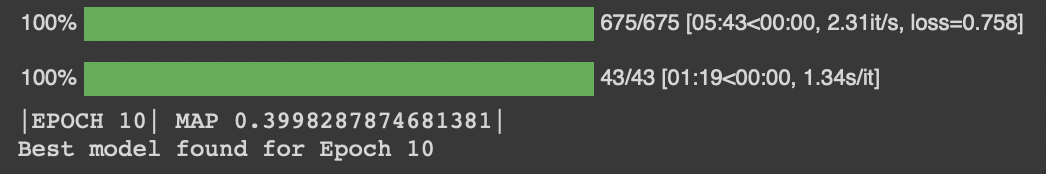

In [ ]:
frcnn_run(df_train_frcnn,df_val_frcnn,fold = 0)

  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 1| MAP 0.2948300936714651|
Best model found for Epoch 1


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 2| MAP 0.32887596455336765|
Best model found for Epoch 2


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 3| MAP 0.3433866791185083|
Best model found for Epoch 3


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 4| MAP 0.3636319739615287|
Best model found for Epoch 4


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 5| MAP 0.3724642717099896|
Best model found for Epoch 5


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 6| MAP 0.38140815425910246|
Best model found for Epoch 6


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 7| MAP 0.38363236095710057|
Best model found for Epoch 7


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 8| MAP 0.38520948757820067|
Best model found for Epoch 8


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 9| MAP 0.38158843257470854|


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 10| MAP 0.3998287874681381|
Best model found for Epoch 10


We can view the Validation images below after training the Faster RCNN model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted 47 BBoxes (blue); Number of GT BBoxes (red) : 55


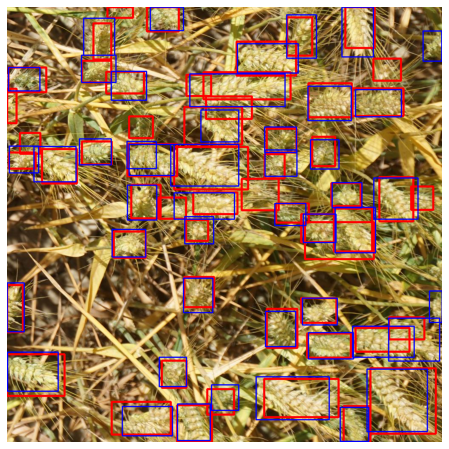

In [ ]:
model = get_model()
# load the best saved weights
model.load_state_dict(torch.load("./FRCNN_best_0.pth"))
# show a prediction
view_sample(df_val_frcnn,
            model = model,
            device = torch.device('cuda'))

<font size = 4>**Run Yolov5 model**</font>

Training the yolov5s model with the exact same parameters as Faster RCNN. The model took roughly 30 mins to train and achieved the best MAP score of 0.459

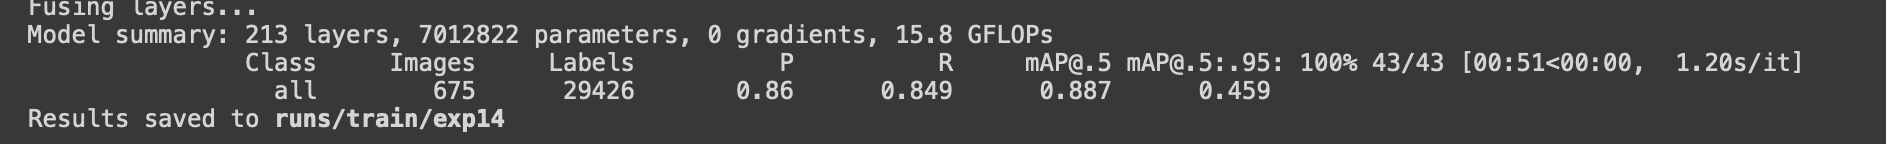

P.S. Please ignore the errors listed below. I was unable to remove them. The model runs fine inspite of them 

In [ ]:
!cd yolov5 && python train.py --img 1024 --batch 8 --epochs 10 --data wheat.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=wheat.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=8, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
error: refs/heads/master does not point to a valid object!
error: refs/remotes/origin/365 does not point to a valid object!
error: refs/remotes/origin/9_target does not point to a valid object!
error: refs/remotes/origin/C5 does not point to a valid object!
error: refs/remotes/origin/C5_breakout does not point to a valid object!
error: refs/remotes/origin/C5_breakout_p5 does not point to a valid object!
error: refs/remotes/origin/C5_

<font size = 4>**Running the yolo model on Test images**</font>

In [ ]:
!cd yolov5 && python detect.py --source /content/drive/MyDrive/wheat_data/global-wheat-detection/test --weights /content/drive/MyDrive/wheat_data/global-wheat-detection/yolov5/runs/train/exp14/weights/best.pt

detect: weights=['/content/drive/MyDrive/wheat_data/global-wheat-detection/yolov5/runs/train/exp14/weights/best.pt'], source=/content/drive/MyDrive/wheat_data/global-wheat-detection/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: HEAD is neither a commit nor blob
YOLOv5 🚀 2022-3-25 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /content/drive/MyDrive/wheat_data/global-wheat-detection/test/2fd875eaa.jpg: 640x640 16 wheats, Done. (0.007s)
image 2/10 /content/drive/MyDrive/wheat_data/global-wheat-detection/test/348a992bb.jpg: 640x640 21 

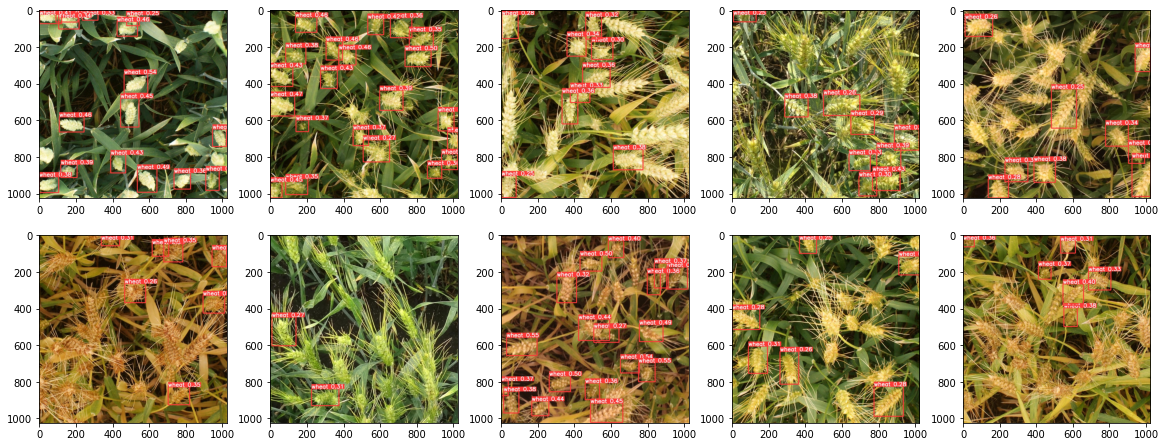

In [ ]:
output_path = '/content/drive/MyDrive/wheat_data/global-wheat-detection/yolov5/runs/detect/exp6'

images=os.listdir(output_path)

img_data=[]
for img in images:
    img_arr=cv2.imread(os.path.join(output_path,img),cv2.IMREAD_COLOR)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_arr /= 255.0
        
    img_data.append(img_arr)

plt.figure(figsize=(20,20))
for i in range(len(img_data)):
    plt.subplot(5,5,i+1)
    plt.imshow(img_data[i])
    

<font size = 5>**Results and discussions**</font>

The Faster RCNN model and the Yolo model are both successful at identifying wheat heads to an extent with MAP@0.95 of 0.399 and 0.459 respectively. Based on these results Yolov5 is a much better model for detection. Additionally Yolov5 is much faster in comparison to Faster RCNN taking less than half the time.

Yolov5 speed can be attributed to its simpler architecture. 

<font size = 5>**Recommendations**</font>

More number of epochs can be run for higher accuracy. When the yolo model was run without any augmentations on the images a much higher MAP@0.95  of 0.535 was achieved at the 10th Epoch and the best in 30 Epochs was 0.557. Image Augmentation dies not help imporove the accuracy in case of Yolov5

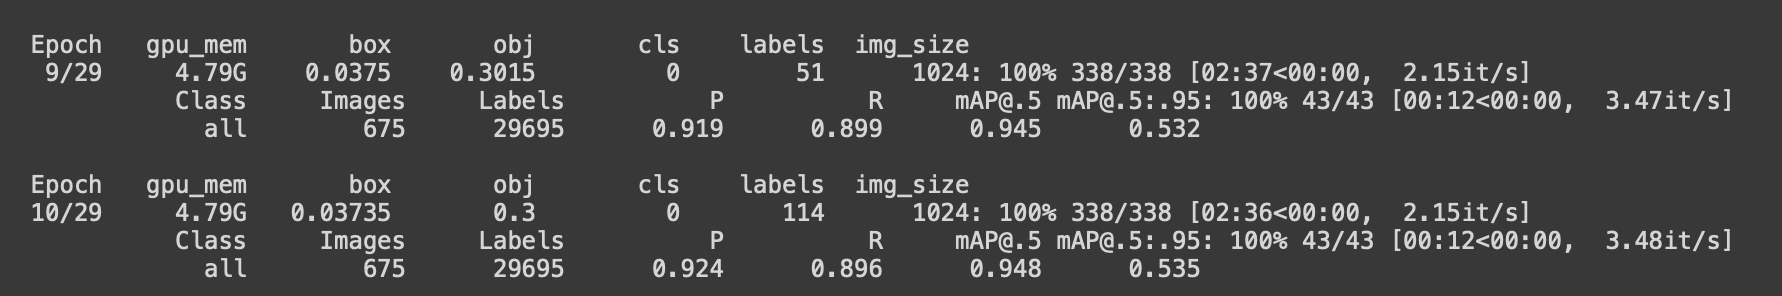

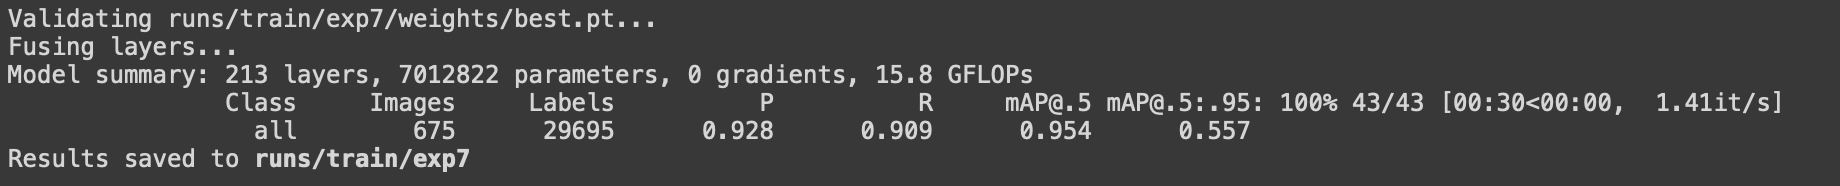

If there is an option I would recommend to go with Yolo instead of Faster RCNN

<font size = 5>**References**</font>



1.   Faster RCNN notebook used: https://www.kaggle.com/code/ChristianDenich/end2end-object-detection-with-fasterrcnn

2.   Yolo model simple explaination: https://www.section.io/engineering-education/introduction-to-yolo-algorithm-for-object-detection/

3. Yolo model: https://www.youtube.com/watch?v=NU9Xr_NYslo&t=1706s

4. Faster RCNN: https://www.youtube.com/watch?v=cReOzRvlLVA&t=80s, https://www.youtube.com/watch?v=iHf2xHQ2VYo&t=9s

5. mAP: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173